# METRO OPERATIONS OPTIMIZATION <HR>
    

# <u> Problem Statement :- 
## Despite the extensive network and frequent services offered by Delhi Metro, overcrowding during peak hours and uneven service distribution remain critical challenges affecting commuter satisfaction and operational efficiency. The primary goal is to optimize metro operations by adjusting the supply (e.g., train frequency, capacity) to better match the demand across different times of the day and various routes.
## By leveraging the available datasets, identify key areas where adjustments in train frequencies could significantly improve the service levels, reduce wait times, and alleviate overcrowding.<hr>

# <U> Steps Involved:- 
### 1. Import Libraries and load dataset
### 2. Data Exploration
### 3. Geographical Visualization
### 4. Trip Frequency Analysis
### 5. Stop Distribution Analysis
### 6. Service Frequency Analysis
### 7. Capacity and Demand Analysis
### 8. Optimization Recommendations <hr>

# IMPORT LIBRARIES

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load Dataset Text File and convert them into csv file

In [2]:
# load all the data files
agency = pd.read_csv('agency.txt')
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
shapes = pd.read_csv('shapes.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
trips = pd.read_csv('trips.txt')

# Data Exploration

In [3]:
data = {
    "agency": agency.head(),
    "calendar": calendar.head(),
    "routes": routes.head(),
    "shapes": shapes.head(),
    "stop_times": stop_times.head(),
    "stops": stops.head(),
    "trips": trips.head()
}

In [4]:
data

{'agency':   agency_id                   agency_name                      agency_url  \
 0      DMRC  Delhi Metro Rail Corporation  http://www.delhimetrorail.com/   
 
   agency_timezone  agency_lang  agency_phone  agency_fare_url  agency_email  
 0    Asia/Kolkata          NaN           NaN              NaN           NaN  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0    weekday       1        1          1         1       1         0       0   
 1   saturday       0        0          0         0       0         1       0   
 2     sunday       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20190101  20251231  
 1    20190101  20251231  
 2    20190101  20251231  ,
 'routes':    route_id  agency_id route_short_name  \
 0        33        NaN           R_SP_R   
 1        31        NaN           G_DD_R   
 2        29        NaN           P_MS_R   
 3        12        NaN             M_JB

# <U> Data Visualization 

## (i) Geographical Path of Delhi Metro Routes

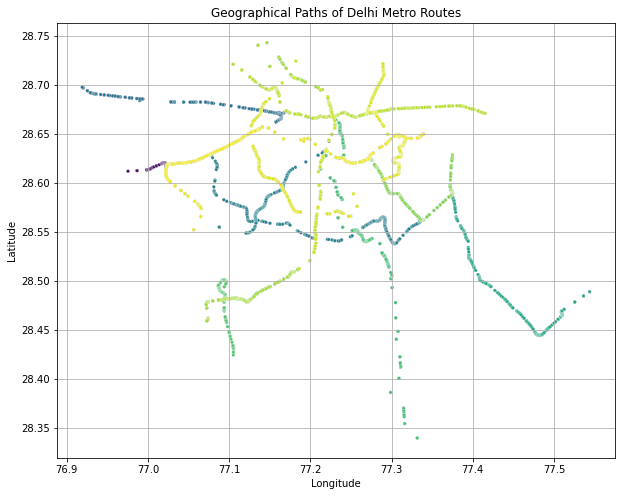

In [5]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='shape_pt_lon', y='shape_pt_lat', hue='shape_id', data=shapes, palette='viridis', s=10, legend=None)
plt.title('Geographical Paths of Delhi Metro Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## (ii) Trip Frequency Analysis - Per Day of the Week

In [29]:
# merge trips with calendar to include the day of operation information
trips_calendar = pd.merge(trips, calendar, on='service_id', how='left')

# count the number of trips per day of the week
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()
trip_counts

monday       5379
tuesday      5379
wednesday    5379
thursday     5379
friday       5379
saturday       59
sunday          0
dtype: int64

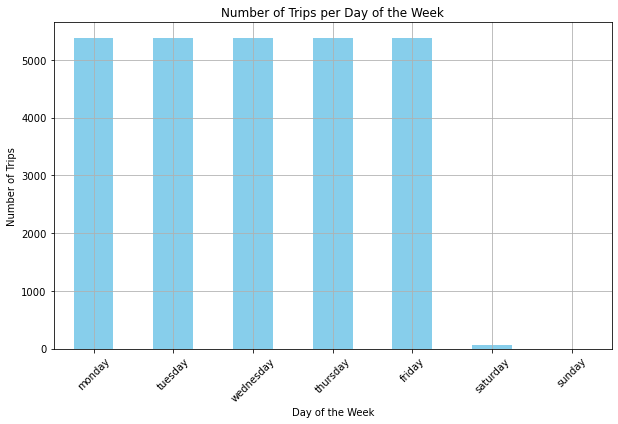

In [28]:
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## (iii) Stop Distribution Analysis - Metro Stop Location Geographically

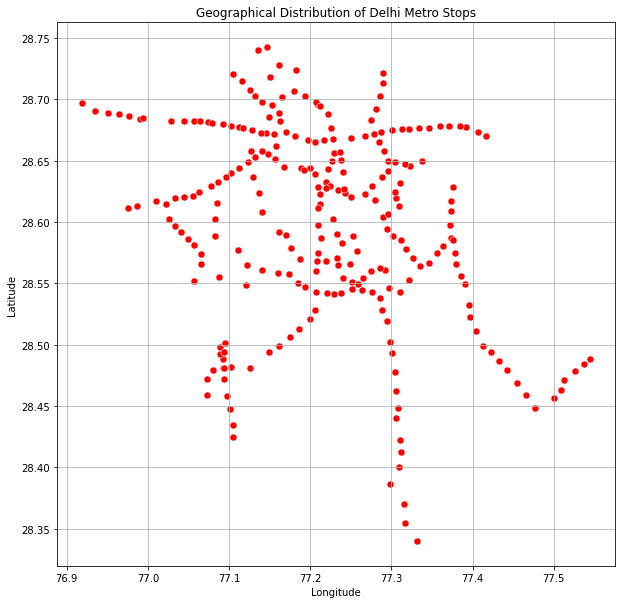

In [7]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='o')
plt.title('Geographical Distribution of Delhi Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Visualize the total no. of routes per stop

Text(0.5, 1.0, 'Number of Routes per Metro Stop in Delhi')

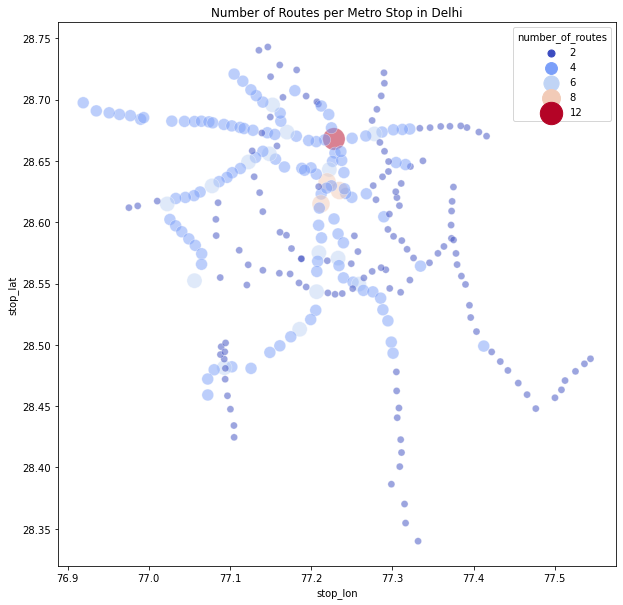

In [11]:
# merge stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

# merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

# plot the number of routes per stop
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 500), alpha=0.5, palette='coolwarm', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop in Delhi')


## (iv) Service frequency Analysis -  Timing intervals between trips during different parts of the day

In [13]:
# function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # Handle cases where the hour might be greater than 23 (e.g., 24:00:00 or 25:00:00)
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

In [31]:
# calculate the difference in arrival times for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

# function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3141458033.py, line 13)

In [17]:
# drop NaN values from intervals (last trip of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# average intervals by time of day (morning, afternoon, evening)
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

C:\Users\USER\AppData\Local\Temp\ipykernel_4280\1388039681.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)


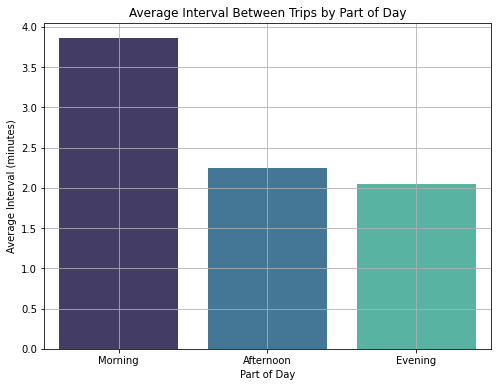

In [18]:
plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')
plt.title('Average Interval Between Trips by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Interval (minutes)')
plt.grid(True)
plt.show()

## (v) Capacity and Demand Analysis - Timings of trips during peak hours

In [30]:
# define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 0):
        return 'Morning Peak'
    elif time < dt.time(16, 0):
        return 'Midday'
    elif time < dt.time(20, 0):
        return 'Evening Peak'
    else:
        return 'Late Evening'

# apply time interval classification
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)

# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})
trips_per_interval

,time_interval,number_of_trips
0,Early Morning,200
1,Evening Peak,1590
2,Late Evening,1378
3,Midday,2152
4,Morning Peak,1280


In [23]:
# sorting the dataframe
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')

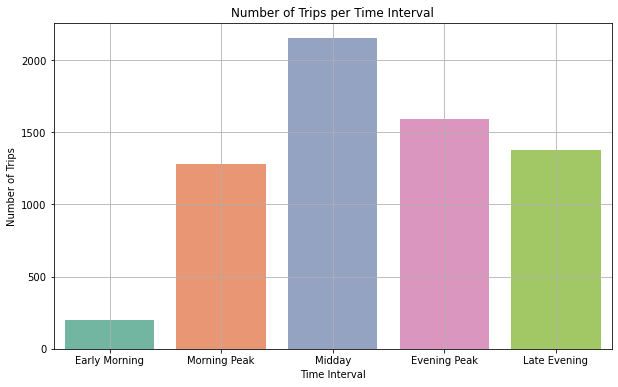

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')
plt.title('Number of Trips per Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

## (vi) Optimization Recommendations - Reduce Overcrowding adjust train frequencies based on time interval analysis.

In [25]:
# adjusting frequencies based on hypothetical scenario
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}

# apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

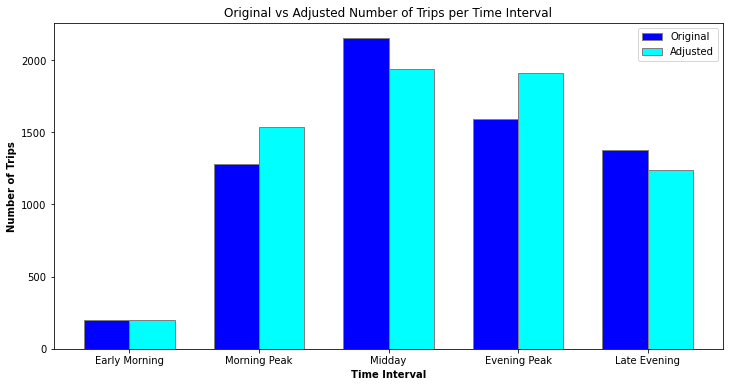

In [26]:
# plotting original vs adjusted number of trips per time interval
plt.figure(figsize=(12, 6))
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='blue', width=bar_width, edgecolor='grey', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='cyan', width=bar_width, edgecolor='grey', label='Adjusted')

plt.xlabel('Time Interval', fontweight='bold')
plt.ylabel('Number of Trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted Number of Trips per Time Interval')
plt.legend()

plt.show()

# <hr> <u> CONCLUSION:- 

## Metro Operations Optimization refers to the systematic process of enhancing the efficiency, reliability, and effectiveness of Metro services through various data-driven techniques and operational adjustments. Our approach to optimizing metro operations showcases how analyzing existing data can guide decisions in real-time scheduling adjustments, even in the absence of explicit passenger count data.